In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.ticker as ticker
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri


In [2]:
injuryData = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/Injuries.csv")

In [3]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
injuryData.rename(columns={'Notes': 'Injury Type'}, inplace=True)
injuryData.rename(columns={'Relinquished': 'Player'}, inplace=True)

### We want to separate the dataset by year to get a good idea of the total number of injuries that have occured annually

In [4]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)



### Let's now remove all rows where the players have been acquired back from the IL 


In [5]:
# Removing the Acquired column removes all duplicates 
injuryData = injuryData[injuryData['Acquired'].isna()]
del injuryData['Acquired']

### Now let's calculate the total sum of injuries for each Year

## `It is important to note that the NBA did not have and IR/IL until the 1989-1990 season. Prior to this injured players were still members of the active roster. For this reason, it's likely many injuries do not appear in the dataset.`

In [6]:
# We only want to include data from the years after 1989 
yearly_injuries = {}
total_injuries = 0
for year, group in injuryData.groupby('Year'):
    if year > 1989: 
        injuries = group.shape[0]
        yearly_injuries[year] = injuries
        total_injuries += injuries
        
df = pd.DataFrame(yearly_injuries.items(), columns=['Year', 'Injuries'])
condition1 = df['Year'].astype(int) <= 2015
df.loc[condition1, 'Players'] = 354
df['isleagueExpansion'] = np.where(df['Year']<=2004, 0, 1)

# Set the condition for the second range of years (1996 onwards)
condition2 = df['Year'].astype(int) > 2015
df.loc[condition2, 'Players'] = 450
df['Players'] = df['Players'].astype(int)

In [7]:
# adding the total number of games played in the NBA each year to the Dataframe
def get_games_played(df):

    games_played = {
      year: 6620
      for year in range(1990, 2024)
  }

  # Update the dictionary for years with a different number of games played.
    games_played[1999] = 4100
    games_played[2011] = 4096
    games_played[2020] = 4384
    games_played[2021] = 4384

  # Create a new column in the DataFrame for the number of games played.
    df['Games Played'] = df.Year.map(games_played)
    df['Games Played'] = df['Games Played'].astype(int)

get_games_played(df)

In [8]:
# Adding feature to account for a shortened season(lockouts and COVID-19 years)
df['Shortened Season'] = np.where(df['Year'].isin([1999, 2011, 2020, 2021]), 1, 0)

In [9]:
# Add feature for average number of miles travelled year over year
# Data on travel data provided by the airball R package by Jose Fernandez (https://github.com/josedv82/airball/blob/master/README.md)
annual_travel = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/AverageTravel.csv")
df = pd.concat([df, annual_travel['Miles Traveled']], axis=1)

In [10]:
# why are there so few injuries in the early in the early 90s
# average NBA salary 


In [11]:
# turning the Players Category into binary values 
df['Players'] = df['Players'].apply(lambda x: 0 if x == 354 else 1)

In [12]:
# Adding the average age of players in the NBA each year 
average_age = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/AveragePlayerAge.csv")
df = pd.concat([df, average_age['Average Age']], axis = 1)
df

,Year,Injuries,Players,isleagueExpansion,Games Played,Shortened Season,Miles Traveled,Average Age
0,1990,64,0,0,6620,0,1292100,27.1
1,1991,66,0,0,6620,0,1272578,27.2
2,1992,28,0,0,6620,0,1318286,27.2
3,1993,33,0,0,6620,0,1323961,27.4
4,1994,127,0,0,6620,0,1320737,27.3
5,1995,245,0,0,6620,0,1330188,27.7
6,1996,277,0,0,6620,0,1408035,27.7
7,1997,290,0,0,6620,0,1433522,28.0
8,1998,157,0,0,6620,0,1397293,28.1
9,1999,396,0,0,4100,1,848528,28.0


In [13]:
# calculating the correlation for the two features I will use to train my model
Players_corr = df['Players'].corr(df['Injuries'])
Year_corr = df['Year'].corr(df['Injuries'])
Games_corr = df['Games Played'].corr(df['Injuries'])
Travel_corr = df['Miles Traveled'].corr(df['Injuries'])
Expansion_corr = df['isleagueExpansion'].corr(df['Injuries'])
Shortened_Season_corr = df['Shortened Season'].corr(df['Injuries'])
Age_corr = df['Average Age'].corr(df['Injuries'])

print("Correlation for Players feature:", Players_corr)
print("Correlation for Year feature:", Year_corr)
print("Correlation for Games Played feature:", Games_corr)
print("Correlation for Miles Traveled feature:", Travel_corr)
print("Correlation for Expansion feature:", Expansion_corr)
print("Correlation for Shortened Season feature:", Shortened_Season_corr)
print("Correlation for Age feature:", Age_corr)

Correlation for Players feature: 0.5759226257184822
Correlation for Year feature: 0.8285992890740163
Correlation for Games Played feature: -0.18779444969532763
Correlation for Miles Traveled feature: 0.1662721634969412
Correlation for Expansion feature: 0.8376745034586539
Correlation for Shortened Season feature: 0.20502095867354034
Correlation for Age feature: -0.7160149034030336


In [14]:
#Using Linear Regression function to fit our model
train_data = df[:26]

X_train = np.array(train_data[['Year', 'Players', 'Games Played', 'Miles Traveled', 'isleagueExpansion', 'Shortened Season', 'Average Age']]).reshape(-1, 7)
y_train = train_data['Injuries']
reg = LinearRegression()


fit_model = reg.fit(X_train, y_train)
print(df.shape)
X_train.shape


(34, 8)


(26, 7)

In [15]:
# using a scikit-learn attribute, the coef represents the wieghts assigned to different features 
print(f"The Weight of feature(s): {fit_model.coef_}")

The Weight of feature(s): [8.90365422e+00 1.90002672e-05 1.66974729e+02 5.84138291e-04
 4.69458876e+02 4.21232769e+05 4.29854194e+01]


In [16]:
# getting the intercept(bias) for our fitted model
print(f"The Bias of the model: {fit_model.intercept_}")

The Bias of the model: -1124930.8136360107


In [17]:
# Adding our insample prediction for each year to our training data set
train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()
train_data.head()

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_5561/1950665895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()


,Year,Injuries,Players,isleagueExpansion,Games Played,Shortened Season,Miles Traveled,Average Age,prediction_insample
0,1990,64,0,0,6620,0,1292100,27.1,79.835985
1,1991,66,0,0,6620,0,1272578,27.2,81.634634
2,1992,28,0,0,6620,0,1318286,27.2,117.238081
3,1993,33,0,0,6620,0,1323961,27.4,138.053804
4,1994,127,0,0,6620,0,1320737,27.3,140.775654


In [18]:
# Calculating the error, MSE, and ABS error for each year
train_data['error'] = train_data.prediction_insample - train_data.Injuries
train_data['squared_error'] = train_data['error']**2
train_data['abs'] = abs(train_data['error'])

train_data

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_5561/2476111573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['error'] = train_data.prediction_insample - train_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_5561/2476111573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['squared_error'] = train_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_5561/2476111573.py:4: SettingWithCopyWarning: 
A value is trying to be 

,Year,Injuries,Players,isleagueExpansion,Games Played,Shortened Season,Miles Traveled,Average Age,prediction_insample,error,squared_error,abs
0,1990,64,0,0,6620,0,1292100,27.1,79.835985,15.835985,250.778426,15.835985
1,1991,66,0,0,6620,0,1272578,27.2,81.634634,15.634634,244.441768,15.634634
2,1992,28,0,0,6620,0,1318286,27.2,117.238081,89.238081,7963.435071,89.238081
3,1993,33,0,0,6620,0,1323961,27.4,138.053804,105.053804,11036.301679,105.053804
4,1994,127,0,0,6620,0,1320737,27.3,140.775654,13.775654,189.768648,13.775654
5,1995,245,0,0,6620,0,1330188,27.7,172.394167,-72.605833,5271.606967,72.605833
6,1996,277,0,0,6620,0,1408035,27.7,226.771235,-50.228765,2522.928842,50.228765
7,1997,290,0,0,6620,0,1433522,28.0,263.458448,-26.541552,704.454005,26.541552
8,1998,157,0,0,6620,0,1397293,28.1,255.497898,98.497898,9701.835828,98.497898
9,1999,396,0,0,4100,1,848528,28.0,396.000000,0.000000,0.000000,0.000000


In [19]:
# I'm not sure why my error is zero 

# Returns the mean for error, squared error and absolute error for the training set
train_data[['error', 'squared_error', 'abs']].mean()

error            1.611904e-10
squared_error    8.216654e+03
abs              7.132814e+01
dtype: float64

Text(0.5, 1.0, 'Number of Injuries Year by Year')

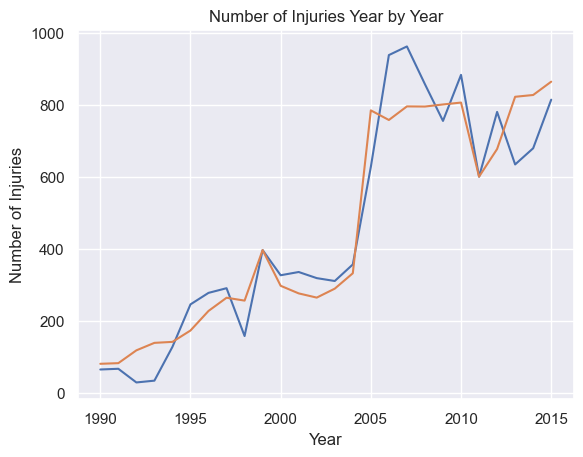

In [20]:
sns.set(style="darkgrid")
sns.lineplot(x=train_data['Year'], y=train_data['Injuries'], data=train_data)
sns.lineplot(x=train_data['Year'], y=train_data['prediction_insample'], data=train_data)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')


### <u>Time to test on a new set of data:<u>

In [23]:
test_data = df[26:]
 
X_test = np.array(test_data[['Year', 'Players', 'Games Played', 'Miles Traveled', 'isleagueExpansion', 'Shortened Season', 'Average Age']]).reshape(-1, 7)
y_test = test_data['Injuries']
X_test

array([[2.016000e+03, 1.000000e+00, 6.620000e+03, 1.429934e+06,
        1.000000e+00, 0.000000e+00, 2.700000e+01],
       [2.017000e+03, 1.000000e+00, 6.620000e+03, 1.452806e+06,
        1.000000e+00, 0.000000e+00, 2.680000e+01],
       [2.018000e+03, 1.000000e+00, 6.620000e+03, 1.464235e+06,
        1.000000e+00, 0.000000e+00, 2.650000e+01],
       [2.019000e+03, 1.000000e+00, 6.620000e+03, 1.437272e+06,
        1.000000e+00, 0.000000e+00, 2.630000e+01],
       [2.020000e+03, 1.000000e+00, 4.384000e+03, 1.091799e+06,
        1.000000e+00, 1.000000e+00, 2.600000e+01],
       [2.021000e+03, 1.000000e+00, 4.384000e+03, 1.206032e+06,
        1.000000e+00, 1.000000e+00, 2.600000e+01],
       [2.022000e+03, 1.000000e+00, 6.620000e+03, 1.409164e+06,
        1.000000e+00, 0.000000e+00, 2.610000e+01],
       [2.023000e+03, 1.000000e+00, 6.620000e+03, 1.300373e+06,
        1.000000e+00, 0.000000e+00,          nan]])

In [22]:
y_pred = fit_model.predict(X_test)
print("Xtest:", X_test)
print("y_pred:", y_pred)
# Adding our insample prediction for each year to our test data set
# test_data.loc[:, 'prediction_insample'] = y_pred.copy()
# test_data.head()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
test_data['error'] = test_data.prediction_insample - test_data.Injuries
test_data['squared_error'] = test_data['error']**2
test_data['abs'] = abs(test_data['error'])

test_data

In [ ]:
df.describe()["Injuries"]

In [ ]:
plt.plot(X_test[:, 0], y_pred, 'r-', label='Predicted Data')
sns.set(style="darkgrid")
sns.lineplot(x=test_data['Year'], y=test_data['Injuries'], data=test_data)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
# Now let's remove all the rows from the data frame that have data before 1990
injuryData = injuryData[injuryData['Year'] >= 1990]